In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
!pip install opendatasets
import opendatasets as od
od.download ('https://www.kaggle.com/datasets/zalando-research/fashionmnist', data_dir= '/content/sample_data')

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist


100%|██████████| 68.8M/68.8M [00:00<00:00, 1.25GB/s]

In [4]:
torch.manual_seed (42)

In [5]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)

cuda


In [6]:
df= pd.read_csv('/content/sample_data/fashionmnist/fashion-mnist_train.csv')

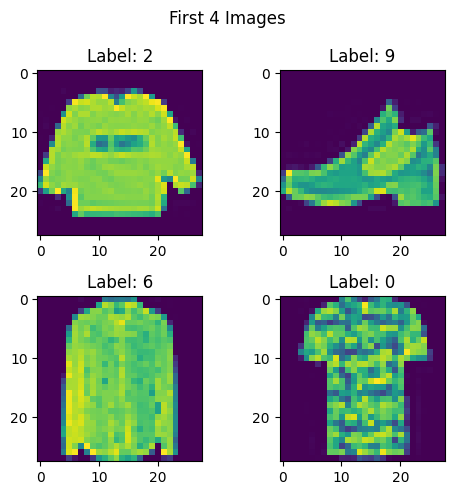

In [7]:
fig, axes= plt.subplots (2,2, figsize=(5,5))
fig.suptitle ('First 4 Images')

# Display the first image
axes[0,0].imshow(df.iloc[0,1:].values.reshape(28,28))
axes[0,0].set_title(f'Label: {df.iloc[0,0]}')

# Display the second image
axes[0,1].imshow(df.iloc[1,1:].values.reshape(28,28))
axes[0,1].set_title(f'Label: {df.iloc[1,0]}')

# Display the third image
axes[1,0].imshow(df.iloc[2,1:].values.reshape(28,28))
axes[1,0].set_title(f'Label: {df.iloc[2,0]}')

# Display the fourth image
axes[1,1].imshow(df.iloc[3,1:].values.reshape(28,28))
axes[1,1].set_title(f'Label: {df.iloc[3,0]}')

plt.tight_layout()
plt.show()

In [8]:
# X_train, X_test, y_train, y_test= train_test_split(df.iloc[:,1:], df.iloc[:,0], test_size=0.2, random_state=42)
X_train = pd.read_csv ('/content/sample_data/fashionmnist/fashion-mnist_train.csv')
y_train = X_train.pop('label')
X_test = pd.read_csv ('/content/sample_data/fashionmnist/fashion-mnist_test.csv')
y_test = X_test.pop('label')
X_train= X_train/255.0
X_test= X_test/255.0

In [9]:
y_train.head()

,label
0,2
1,9
2,6
3,0
4,3


In [25]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

class mnist (Dataset):
  def __init__(self, features, labels):
    #convert the data to pytorch tebnsors
    self.features = torch.tensor(features.values, dtype= torch.float32).reshape(-1,1,28,28)
    self.labels= torch.tensor (labels.values, dtype= torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__ (self, index):
    return self.features[index], self.labels[index]

In [26]:
train_data= mnist(X_train, y_train)
test_data= mnist(X_test, y_test)

In [27]:
train_loader= DataLoader (train_data, batch_size= 64, shuffle= True, pin_memory= True)
test_loader = DataLoader (test_data, batch_size= 64, shuffle= False, pin_memory = True)

In [ ]:
class CNN (nn.Module):
  def __init__ (self, input_features):
    super().__init__()

    self.features= nn.Sequential (
      nn.Conv2d (input_features, 32, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.BatchNorm2d (32),
      nn.MaxPool2d (kernel_size=2, stride=2),


      #another conv layer
      nn.Conv2d (32, 64, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.BatchNorm2d (64),
      nn.MaxPool2d (kernel_size=2, stride=2),

      #another
      nn.Conv2d(64,128, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.BatchNorm2d (128),
      nn.MaxPool2d (kernel_size=2, stride=2),

      #flatten
      nn.Flatten ()
    )
    self.classifier= nn.Sequential (
      nn.Linear ( 128*3*3, 128),
      nn.ReLU(),
      nn.BatchNorm1d (128),
      nn.Dropout(0.3),

      nn.Linear (128,64),
      nn.ReLU(),
      nn.BatchNorm1d (64),
      nn.Dropout(0.4),

      nn.Linear (64,10)
    )
  def forward (self,x):
    x= self.features(x)
    x= self.classifier(x)
    return x

In [16]:
lr= 0.01
epochs = 5

In [ ]:
model = CNN(1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay= 1e-4 )

In [ ]:
for epoch in range (epochs):
  total_epoch_loss= 0
  for batch_features, batch_labels in train_loader:
    #moving to gpu
    batch_features, batch_labels= batch_features.to(device), batch_labels.to(device)

    #forward pass
    output= model(batch_features)
    #loss
    loss= criterion(output, batch_labels)
    #reverse pass
    optimizer.zero_grad()
    loss.backward()
    #upgrading gradients
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()
  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch:{epoch} Loss:{avg_loss}')


Epoch:0 Loss:0.4817857675905675
Epoch:1 Loss:0.3982106527285789
Epoch:2 Loss:0.3460238225646873
Epoch:3 Loss:0.3346027662155471
Epoch:4 Loss:0.3280967631176718


In [ ]:
model.eval()
total= 0
correct =0
with torch.no_grad ():
  for batch_features, batch_labels in test_loader:

    #moving to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels. to (device)

    #forward
    outputs= model (batch_features)
    _, prediction = torch.max (outputs, 1)

    # accuracy
    total = total + batch_labels.shape [0]

    correct = correct + (prediction==batch_labels).sum ().item ()

    accuracy = correct/ total
  print ('Accuracy',accuracy)

Accuracy 0.908


## Optuna Based Hypertuning

In [13]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 15.9 MB/s eta 0:00:00


In [18]:
import optuna
import torch.nn as nn
import torch.optim as optim

def objective(trial):
    # Define hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5) # Single dropout rate for all hidden layers
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)

    # Tune the number of convolutional layers
    n_conv_layers = trial.suggest_int('n_conv_layers', 1, 4)
    conv_layers = []
    in_channels = 1
    for i in range(n_conv_layers):
        out_channels = trial.suggest_int(f'conv_{i}_out_channels', 16, 128, step=16)
        kernel_size = trial.suggest_int(f'conv_{i}_kernel_size', 3, 5, step=2)
        conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding='same'))
        conv_layers.append(nn.ReLU())
        conv_layers.append(nn.BatchNorm2d(out_channels))
        conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        in_channels = out_channels

    # Calculate the size of the flattened layer
    # We need to pass a dummy tensor through the conv layers to determine the size
    dummy_input = torch.randn(1, 1, 28, 28)
    dummy_conv_output = nn.Sequential(*conv_layers)(dummy_input)
    flattened_size = dummy_conv_output.view(dummy_conv_output.size(0), -1).size(1)


    # Tune the number of hidden layers and neurons
    n_hidden_layers = trial.suggest_int('n_hidden_layers', 1, 5) # Increased range for hidden layers
    hidden_layers = []
    current_input_dim = flattened_size
    for i in range(n_hidden_layers):
        out_features = trial.suggest_int(f'hidden_{i}_out_features', 32, 256, step=32)
        hidden_layers.append(nn.Linear(current_input_dim, out_features))
        hidden_layers.append(nn.ReLU())
        hidden_layers.append(nn.BatchNorm1d(out_features))
        hidden_layers.append(nn.Dropout(dropout_rate)) # Use the single tunable dropout rate
        current_input_dim = out_features

    # Output layer
    hidden_layers.append(nn.Linear(current_input_dim, 10))


    # Build the model with suggested hyperparameters
    class TunedCNN (nn.Module):
        def __init__ (self, conv_layers, hidden_layers):
            super().__init__()
            self.features = nn.Sequential(*conv_layers)
            self.classifier = nn.Sequential(*hidden_layers)

        def forward (self,x):
            x= self.features(x)
            x= x.view(x.size(0), -1) # Flatten the output from convolutional layers
            x= self.classifier(x)
            return x

    model = TunedCNN(conv_layers, hidden_layers).to(device)


    # Define optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    criterion = nn.CrossEntropyLoss()

    # Training loop (simplified for objective function)
    epochs = 5 # Define epochs inside the objective function
    model.train()
    for epoch in range(epochs):
        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    accuracy = correct / total
    return accuracy

In [19]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # You can adjust the number of trials

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-09-08 14:06:55,419] A new study created in memory with name: no-name-5868fc13-acc8-4e63-9ede-4f5227407eda
[I 2025-09-08 14:07:28,057] Trial 0 finished with value: 0.9052 and parameters: {'lr': 0.00043851658786128256, 'optimizer': 'RMSprop', 'dropout_rate': 0.12747752813905713, 'weight_decay': 0.003539532510421795, 'n_conv_layers': 3, 'conv_0_out_channels': 112, 'conv_0_kernel_size': 5, 'conv_1_out_channels': 16, 'conv_1_kernel_size': 5, 'conv_2_out_channels': 64, 'conv_2_kernel_size': 5, 'n_hidden_layers': 4, 'hidden_0_out_features': 128, 'hidden_1_out_features': 256, 'hidden_2_out_features': 160, 'hidden_3_out_features': 128}. Best is trial 0 with value: 0.9052.
[I 2025-09-08 14:07:58,893] Trial 1 finished with value: 0.9043 and parameters: {'lr': 0.0027852029748218926, 'optimizer': 'Adam', 'dropout_rate': 0.15807383464376243, 'weight_decay': 0.00016760910568389877, 'n_conv_layers': 4, 'conv_0_out_channels': 16, 'conv_0_kernel_size': 5, 'conv_1_out_channels': 16, 'conv_1_kerne

Best trial:
  Value: 0.9261
  Params: 
    lr: 0.0002711582397741778
    optimizer: Adam
    dropout_rate: 0.39971235741208533
    weight_decay: 0.001470469575728444
    n_conv_layers: 2
    conv_0_out_channels: 32
    conv_0_kernel_size: 3
    conv_1_out_channels: 96
    conv_1_kernel_size: 5
    n_hidden_layers: 4
    hidden_0_out_features: 224
    hidden_1_out_features: 160
    hidden_2_out_features: 64
    hidden_3_out_features: 96


In [31]:
class CNN (nn.Module):
  def __init__ (self, input_features):
    super().__init__()

    self.features= nn.Sequential (
      nn.Conv2d (input_features, 32, kernel_size=3, padding='same'),
      nn.ReLU(),
      nn.BatchNorm2d (32),
      nn.MaxPool2d (kernel_size=2, stride=2),


      #another conv layer
      nn.Conv2d (32, 96, kernel_size=5, padding='same'),
      nn.ReLU(),
      nn.BatchNorm2d (96),
      nn.MaxPool2d (kernel_size=2, stride=2),

      #flatten
      nn.Flatten ()
    )
    self.classifier= nn.Sequential (
      nn.Linear ( 96*7*7, 224),
      nn.ReLU(),
      nn.BatchNorm1d (224),
      nn.Dropout(0.399),

      nn.Linear (224,160),
      nn.ReLU(),
      nn.BatchNorm1d (160),
      nn.Dropout(0.399),

      nn.Linear (160,64),
      nn.ReLU(),
      nn.BatchNorm1d (64),
      nn.Dropout(0.399),

      nn.Linear (64,96),
      nn.ReLU(),
      nn.BatchNorm1d (96),
      nn.Dropout(0.399),

      nn.Linear (96,10)
    )
  def forward (self,x):
    x= self.features(x)
    x= self.classifier(x)
    return x

In [32]:
model = CNN(1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000271,weight_decay= 0.00147 )

In [35]:
for epoch in range (epochs):
  total_epoch_loss= 0
  for batch_features, batch_labels in train_loader:
    #moving to gpu
    batch_features, batch_labels= batch_features.to(device), batch_labels.to(device)

    #forward pass
    output= model(batch_features)
    #loss
    loss= criterion(output, batch_labels)
    #reverse pass
    optimizer.zero_grad()
    loss.backward()
    #upgrading gradients
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()
  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch:{epoch} Loss:{avg_loss}')

model.eval()
correct = 0
total = 0
with torch.no_grad():
  for batch_features, batch_labels in test_loader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    outputs = model(batch_features)
    _, predicted = torch.max(outputs.data, 1)
    total += batch_labels.size(0)
    correct += (predicted == batch_labels).sum().item()

  accuracy = correct / total
print ('Accuracy', accuracy)


Epoch:0 Loss:0.18155216102772304
Epoch:1 Loss:0.154059145655205
Epoch:2 Loss:0.1389530837061261
Epoch:3 Loss:0.1257666142732858
Epoch:4 Loss:0.11209986618420145
Accuracy 0.9236


In [37]:
# Get the best hyperparameters
best_params = study.best_trial.params

# Extract hyperparameters
lr = best_params['lr']
optimizer_name = best_params['optimizer']
dropout_rate = best_params['dropout_rate'] # Using the single dropout rate
weight_decay = best_params['weight_decay']
n_conv_layers = best_params['n_conv_layers']
n_hidden_layers = best_params['n_hidden_layers']

# Build the convolutional layers using the best parameters
conv_layers = []
in_channels = 1
for i in range(n_conv_layers):
    out_channels = best_params[f'conv_{i}_out_channels']
    kernel_size = best_params[f'conv_{i}_kernel_size']
    conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding='same'))
    conv_layers.append(nn.ReLU())
    conv_layers.append(nn.BatchNorm2d(out_channels))
    conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    in_channels = out_channels

# Calculate the size of the flattened layer
# We need to pass a dummy tensor through the conv layers to determine the size
dummy_input = torch.randn(1, 1, 28, 28)
dummy_conv_output = nn.Sequential(*conv_layers)(dummy_input)
flattened_size = dummy_conv_output.view(dummy_conv_output.size(0), -1).size(1)


# Build the hidden layers using the best parameters
hidden_layers = []
current_input_dim = flattened_size
for i in range(n_hidden_layers):
    out_features = best_params[f'hidden_{i}_out_features']
    hidden_layers.append(nn.Linear(current_input_dim, out_features))
    hidden_layers.append(nn.ReLU())
    hidden_layers.append(nn.BatchNorm1d(out_features))
    hidden_layers.append(nn.Dropout(dropout_rate)) # Apply the single best dropout rate
    current_input_dim = out_features

# Output layer
hidden_layers.append(nn.Linear(current_input_dim, 10))


# Define the final model with the best hyperparameters
class FinalCNN (nn.Module):
    def __init__ (self, conv_layers, hidden_layers):
        super().__init__()
        self.features = nn.Sequential(*conv_layers)
        self.classifier = nn.Sequential(*hidden_layers)

    def forward (self,x):
        x= self.features(x)
        x= x.view(x.size(0), -1) # Flatten the output from convolutional layers
        x= self.classifier(x)
        return x

model = FinalCNN(conv_layers, hidden_layers).to(device)

# Define optimizer with best hyperparameters
if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
else:
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 5 # Using the same number of epochs as in the objective function
model.train()
for epoch in range(epochs):
    total_epoch_loss= 0
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_epoch_loss = total_epoch_loss + loss.item()
    avg_loss = total_epoch_loss/len(train_loader)
    print(f'Epoch:{epoch} Loss:{avg_loss}')

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

accuracy = correct / total
print ('Accuracy',accuracy)

Epoch:0 Loss:0.7509433475892935
Epoch:1 Loss:0.40201148940428993
Epoch:2 Loss:0.32924525724100406
Epoch:3 Loss:0.29498320248430726
Epoch:4 Loss:0.26521046775013907
Accuracy 0.916
